# Progressif sans data aug : 76.7%

In [1]:
%%time

num_aug=1


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

from glob import glob
import os


imPath = "Database/All_pictures/"
ls_path = glob(os.path.join(imPath, '*' ))

images_base_vide=[]
label_nom_vide=[]

for file in ls_path: 
    im = np.array(Image.open(file))[:,:,3]   #On charge l'image
    images_base_vide+=[im]
    label_nom_vide+=[file.split('\\')[1].split('_')[0]]   ## Attention ici Solène si ça marche pas . Pas meme code pour chemin ...

images_base_raw=np.array(images_base_vide)
label_nom_raw=np.array(label_nom_vide)

def print_exemple_image(num_image,X=images_base_raw,y=label_nom_vide) :
    plt.imshow(X[num_image],cmap='Greys')
    plt.suptitle("Image n°"+str(num_image)+" : "+str(y[num_image]), fontsize=20)
    
from sklearn.model_selection import train_test_split

ramdom_seed_fixée=5

def get_split_classique() :
    return train_test_split(images_base_raw, label_nom_raw, test_size=0.20, random_state=ramdom_seed_fixée)

X_train_classique , X_test_classique , Y_train_classique , Y_test_classique = get_split_classique()

label_to_OneHot = {'Deezer':[1,0,0,0],'Messenger':[0,1,0,0],'Facebook':[0,0,1,0],'Tinder':[0,0,0,1]}
label_to_num = {'Deezer':0 ,'Messenger':1 ,'Facebook':2,'Tinder':3} 
num_to_label={0:'Deezer',1:'Messenger' ,2:'Facebook',3:'Tinder'}

def transformation_dictionnaire_image(X,Y,data_aug=1,num_pixel_cote=64) : 
    taille = X.shape[0]
    data_base={'image':[], 'data': [], 'label_num' : [],'label_OneHot' : [],'nom_label' :[]}
    for i in range(taille) : 
        im = cv2.resize(X[i], (num_pixel_cote,num_pixel_cote))
        name=Y[i]
        
        for k in range(data_aug):
            num_rows, num_cols = im.shape[:2]
            rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), k*5, 1)
            im_rotation = cv2.warpAffine(im, rotation_matrix, (num_cols, num_rows))
        
            
            data_base['image']+=[im_rotation]
            data_base['data']+=[np.ndarray.flatten(im_rotation)]
            data_base['label_num']+=[label_to_num[name]]
            data_base['label_OneHot']+=[label_to_OneHot[name]]
            data_base['nom_label']+=[name]
            
            
    data_base['image']=np.array( data_base['image'])
    data_base['data']=np.array(data_base['data'])
    data_base['label_num']=np.array(data_base['label_num'])
    data_base['label_OneHot']=np.array(data_base['label_OneHot'])
    data_base['nom_label']=np.array(data_base['nom_label'])
    
    return data_base
        
Train_Classique = transformation_dictionnaire_image(X_train_classique,Y_train_classique,data_aug=num_aug)
Test_Classique = transformation_dictionnaire_image(X_test_classique,Y_test_classique)

catégories= ['Deezer','Facebook','Messenger','Tinder']

X_train_progressif , X_test_progressif , Y_train_progressif , Y_test_progressif = [],[],[],[]

for cat in catégories : 
    imPath = "Database/"+cat+"/"
    ls_path = glob(os.path.join(imPath, '*' ))

    taille_train=len(ls_path)-len(ls_path)//5
    #Train
    for file in ls_path[:taille_train]: 
        im = np.array(Image.open(file))[:,:,3]   #On charge l'image
        X_train_progressif+=[im]
        Y_train_progressif+=[file.split('\\')[1].split('_')[0]]

    #Test
    for file in ls_path[taille_train:]: 
        im = np.array(Image.open(file))[:,:,3]   #On charge l'image
        X_test_progressif+=[im]
        Y_test_progressif+=[file.split('\\')[1].split('_')[0]]
    

X_train_progressif=np.array(X_train_progressif)
Y_train_progressif=np.array(Y_train_progressif)
X_test_progressif=np.array(X_test_progressif)
Y_test_progressif=np.array(Y_test_progressif)


Train_Progressif = transformation_dictionnaire_image(X_train_progressif,Y_train_progressif,data_aug=num_aug)
Test_Progressif = transformation_dictionnaire_image(X_test_progressif,Y_test_progressif)

Wall time: 1min 8s


In [2]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import random

In [3]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [4]:
Train_dic=Train_Progressif
Test_dic=Test_Progressif

In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(Train_dic['image'].shape[0]))
print("- Test-set:\t\t{}".format(Test_dic['image'].shape[0]))

Size of:
- Training-set:		1211
- Test-set:		300


In [6]:
# The number of pixels in each dimension of an image.
img_size = Train_dic['image'].shape[1]

# The images are stored in one-dimensional arrays of this length.
img_size_flat = Train_dic['data'].shape[1]

# Tuple with height and width of images used to reshape arrays.
img_shape = Train_dic['image'].shape[1:]

# Number of classes, one class for each of 10 digits.
num_classes = 4 

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3,  figsize=(10,5))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

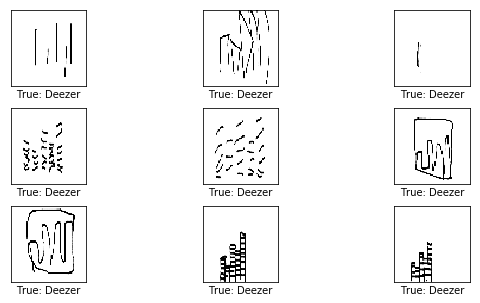

In [8]:
# Get the first images from the test-set.
images = Train_dic['image'][0:9]

# Get the true classes for those images.
cls_true = [num_to_label[i] for i in Train_dic['label_num'][0:9]]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [9]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [10]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [11]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [12]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [13]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [14]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [15]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [16]:
y_true_cls = tf.argmax(y_true, axis=1)

In [17]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [18]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 32, 32, 16) dtype=float32>

In [19]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [20]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 16, 16, 36) dtype=float32>

In [21]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [22]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 9216) dtype=float32>

In [23]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [24]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [25]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [26]:
y_pred = tf.nn.softmax(layer_fc2)

In [27]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [28]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [29]:
cost = tf.reduce_mean(cross_entropy)

In [30]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [31]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [32]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [33]:
session = tf.Session()

In [34]:
session.run(tf.global_variables_initializer())

In [35]:
train_batch_size = 64

In [36]:
def get_random_batch(X,y,batch_size) :
    index=random.sample(range(1,y.shape[0]), batch_size)
    return X[index], y[index]

In [37]:
# Counter for total number of iterations performed so far.
total_iterations = 0
batch_size=100

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = get_random_batch(Train_dic['data'],Train_dic['label_OneHot'],batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [38]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = Test_dic['data'][incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = Test_dic['label_num'][incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=[num_to_label[i] for i in cls_true[0:9]],
                cls_pred=[num_to_label[i] for i in cls_pred[0:9]])

In [39]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = Test_dic['label_num']

    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
    plt.yticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [40]:
feed_dict_test = {x: Test_dic['data'],
                  y_true: Test_dic['label_OneHot'],
                  y_true_cls: Test_dic['label_num']}

In [41]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [42]:
print_accuracy()

Accuracy on test-set: 27.7%


In [43]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  23.0%
Time usage: 0:00:02


In [44]:
print_accuracy()

Accuracy on test-set: 26.3%


In [45]:
for i in range(10): 
    optimize(num_iterations=100) 
    print_accuracy()

Optimization Iteration:    101, Training Accuracy:  89.0%
Time usage: 0:02:14
Accuracy on test-set: 68.3%
Optimization Iteration:    201, Training Accuracy:  99.0%
Time usage: 0:01:56
Accuracy on test-set: 72.3%
Optimization Iteration:    301, Training Accuracy:  99.0%
Time usage: 0:01:55
Accuracy on test-set: 73.3%
Optimization Iteration:    401, Training Accuracy:  99.0%
Time usage: 0:01:53
Accuracy on test-set: 74.3%
Optimization Iteration:    501, Training Accuracy:  99.0%
Time usage: 0:01:50
Accuracy on test-set: 76.3%
Optimization Iteration:    601, Training Accuracy: 100.0%
Time usage: 0:01:52
Accuracy on test-set: 74.0%
Optimization Iteration:    701, Training Accuracy: 100.0%
Time usage: 0:01:51
Accuracy on test-set: 75.7%
Optimization Iteration:    801, Training Accuracy:  96.0%
Time usage: 0:01:54
Accuracy on test-set: 75.0%
Optimization Iteration:    901, Training Accuracy: 100.0%
Time usage: 0:01:54
Accuracy on test-set: 76.3%
Optimization Iteration:   1001, Training Accur